In [218]:
#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'modelproject'))
	print(os.getcwd())
except:
	pass

/Users/thomasmidjord/Desktop/KU Polit/8. semester/Introduction To Programming And Numerical Analysis/Workflow/projects-2019-tm-and-mp/modelproject/modelproject


Imports and set magics:

In [219]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import linalg
from scipy import optimize
import sympy as sm

# To print nicely:
sm.init_printing(use_unicode=True)

# autoreload modules when code is run
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The basic Solow model

The basic Solow model is as follows:

\begin{align}
Y_t = AK_t^{\alpha}L_t^{1-\alpha} \quad \quad (1) \\ \\
S_t = sY_t \quad \quad (2) \\ \\
K_{t+1} - K_t = S_t -\delta K_t \quad \quad (3) \\ \\
L_{t+1} = (1-n)L_t \quad \quad (4)
\end{align}

We also define the following equations:
\begin{align}
y_t = \frac{Y_t}{L_t} = Ak_t^{\alpha} \quad \quad (5) \\ \\
k_t = \frac{K_t}{L_t} \quad \quad (6)
\end{align}

## Defining symbols

First we define the necessary variables so we can use sympy:

In [220]:
Y = sm.symbols("Y_t")
y = sm.symbols("y_t")
K = sm.symbols("K_t")
k = sm.symbols("k_t")
r = sm.symbols("r_t")
w = sm.symbols("w_t")
s = sm.symbols("s")
n = sm.symbols("n")
g = sm.symbols("g")
A = sm.symbols("A")
L = sm.symbols("L_t")
alpha = sm.symbols("alpha")
delta = sm.symbols("delta")
kstar = sm.symbols("k_t^*")
ystar = sm.symbols("y^*")

## Finding FOC:

In [221]:
r_foc = sm.simplify(sm.diff(A*K**alpha*L**(1-alpha),K))
sm.Eq(r, r_foc)

In [222]:
w_foc = sm.simplify(sm.diff(A*K**alpha*L**(1-alpha),L))
sm.Eq(w, w_foc)

## Solving for steady state

We insert (1) in (2) and inserting this into (3). Then we divide by $L_t$ and solve the equation knowing that in steady state $k_{t+1} = k_t = k^*$. The equation we are solving can then be simplified to: $sAk^{\alpha} - (n-\delta)k = 0$

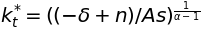

In [223]:
ksteady = sm.solve(s*A*k**alpha-(n-delta)*k, k)[0]
sm.Eq(kstar , ksteady)

Inserting this result into (5) gives us $y^*$:

In [224]:
y_star = sm.simplify(A*ksteady**alpha)
sm.Eq(ystar, y_star)

## Simulating the basic Solow model

In [225]:
def simulate_basic(alpha,delta,s,n,A,T):
    """
    Args:
    alpha (float): Capital income share
    delta (float): Capital depreciation rate
    s (float): Savings rate
    n (float): Labor force growth rate
    A (float): Total factor productivity
    T (int): Periods to simulate through
    
    Returns:
    A plot showing how capital per worker accumulates over time"""
    
    #First we make a list for our future values of capital accumulation to be in
    k_path = [0]
    
    #Then we make a list which will contain the values for the 45-degree-line
    Degreeline = [0]
    
    #We generate the 45-degree-line represeting capital per worker depreciation
    for t in range(1,T):
        line = (n + delta)*t
        Degreeline.append(line)
        
    #We generate the capital accumulation
    for t in range(1,T):
        k_plus = s*A*t**alpha
        k_path.append(k_plus)
    
    #Plotting the two lines
    plt.figure(figsize=(5,5))
    plt.plot(k_path[:T], label='$sAk_t^{\u03B1}$')
    plt.plot(Degreeline[:T], label = '$(n+\delta)k_t$')
    plt.xlim(0,T)
    plt.ylim(0,Degreeline[-1])
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    
    return plt.show()

Example on a simulation with reasonable values:

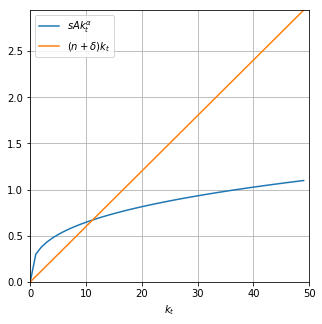

In [226]:
simulate_basic(1/3,0.05,0.3,0.01,1,50)

Below, you can try changing the parametres yourself by moving the sliders to see how different parameter values changes the steady state.

In [227]:
widgets.interact(simulate_basic,
                alpha = widgets.FloatSlider(description = '$\u03B1$' , min = 0 , max = 0.9 , step = 0.05 , value = 0.3),
                delta = widgets.FloatSlider(description = '$\u03B4$' , min = 0 , max = 0.1 , step = 0.01 , value = 0.05),
                s = widgets.FloatSlider(description = 's' , min = 0 , max = 0.8 , step = 0.05 , value = 0.3),
                n = widgets.FloatSlider(description ='$n$', min = 0 , max = 0.1 , step = 0.005, value = 0.01),
                A = widgets.fixed(1),
                T = widgets.IntSlider(description='$T$' , min = 0, max = 200, step = 10, value = 50))

interactive(children=(FloatSlider(value=0.3, description='$α$', max=0.9, step=0.05), FloatSlider(value=0.05, d…

<function __main__.simulate_basic(alpha, delta, s, n, A, T)>

# The Solow-model with land

The Solow-model with land is as follows:
\begin{align}
Y_t = K_t^{\alpha}(A_tL_t)^{\beta}X^{\kappa}, \quad \alpha + \beta + \kappa = 1. \quad \quad (7) \\ \\
K_{t+1} = sY_t+(1-\delta)K_t, \quad K_0 \text{ given}. \quad \quad (8) \\ \\
L_{t+1} = (1+n)L_t, \quad n≥0, \quad L_0 \text{ given}. \quad \quad (9) \\ \\
A_{t+1} = (1+g)A_t, \quad g≥0, \quad A_0 \text{ given}. \quad \quad (10)
\end{align}
* $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$)
* $A_t$ is technology (growing with a constant rate of $g$)
* $X$ is land (constant)
<br> <br>
* $s$ is the savings rate (which is assumed to be constant)

**Saving** is a constant fraction of GDP
$$ S_t = sY_t,\,s\in(0,1) $$
Defining the following variables:

$$ \text{Capital-output ratio:} \quad z_t=\frac{K_t}{Y_t} $$

$$ \text{Capital per worker:} \quad k_t=\frac{K_t}{L_t} $$

$$ \text{Land per worker:} \quad x_t=\frac{X_t}{L_t} $$

$$ \text{Output per worker:} \quad y_t=\frac{Y_t}{L_t} $$

$$ y_t = k_t^\alpha A_t^\beta x_t^\kappa \quad \quad (11)$$

## Defining symbols

First we define all necessary **symbols** so we can use sympy:

In [228]:
z = sm.symbols('z_t')
v = sm.symbols('v_t')
beta = sm.symbols('beta')
kappa = sm.symbols('kappa')
zstar = sm.symbols('z^*')
x = sm.symbols('x_t')
X = sm.symbols('X')
A0 = sm.symbols('A_0')
L0 = sm.symbols('L_0')

## Finding FOC:

In [229]:
r_foc_land = sm.simplify(sm.diff(K**alpha*(A*L)**beta*X**kappa,K))
sm.Eq(r, r_foc_land)

In [230]:
w_foc_land = sm.simplify(sm.diff(K**alpha*(A*L)**beta*X**kappa,L))
sm.Eq(w, w_foc_land)

In [231]:
v_foc_land = sm.simplify(sm.diff(K**alpha*(A*L)**beta*X**kappa,X))
sm.Eq(v, v_foc_land)

# Steady state

We are working with the transition equation for the capital-output ratio (z)

$$ z_{t+1} = \left(\frac{1}{(1+n)(1+g)}\right)^\beta [(s+(1-\delta)z_t)]^{1-\alpha} z_t^\alpha $$

Solving for z to find z* where we use that in steady state $z_{t+1} = z_t = z^*$

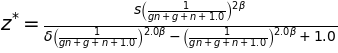

In [249]:
# Solving the z equation using Sympy only works for certain values of alpha.
# We choose alpha to be 0.5. Setting alpha to 0.5 is perhaps too high, 
# as imperical studies using a Solow model with land suggests that alpha is closer to 0.2,
# but we only made the calculations work with 0.5
alpha = 0.5

# Calculating the capital-ouput ratio (z) for the chosen value of alpha
z_eq = sm.Eq(zstar, (1/((1+n)*(1+g)))**beta * (s+(1-delta)*zstar)**(1-alpha)*zstar**alpha)
z_solve = sm.simplify(sm.solve(z_eq, zstar)[1])
zfinal = sm.Eq(zstar, z_solve)
zfinal

$z^*$ can also be reduced to the following for a given $\alpha$ value

$$ z^* = \frac{s}{[(1+n)(1+g)]^{\frac{\beta}{1-\alpha}}-(1-\delta)} $$

We create a function that gives us steady state value of $z^*$

In [239]:
ss_z = sm.lambdify((beta, delta, n, g, s), z_solve)
def steady_state_z(beta, delta, n, g, s):
    
    """Returns steady state values for capital-output ratio (z)
    Args:
    alpha (float): Capital income share
    beta  (float): Labor income share
    kappa (float): Land income share
    delta (float): Capital depreciation rate
    n (float): Labor force growth rate
    g (float): Technological growth rate
    s (float): Savings rate
    A0 (float): Initital techonological level
    X (float): Land (square kilometers)
    L0 (float): Inital labor force 
    
    Returns:
    Steady state values for z"""
    
    ssz = ss_z(beta, delta, n, g, s)
    
    return ssz

In [240]:
ssz_value = steady_state_z(0.2,0.05,0.01,0.02,0.3)
print('Steady state for z is ' + str(round(ssz_value,2)))

Steady state for z is 4.84


We are finding $y^*$ by using (11):

$$ y_t = k_t^\alpha A_t^\beta x_t^\kappa $$

We devide by $y_t^\alpha$ and find:

$$ y_t^{1-\alpha} = z_t^\alpha A_t^\beta x_t^\kappa $$

Isolating $y_t$ and inserting $z^*$ gives us $y_t^*$:

$$ y_t^* = (z^*)^{\frac{\alpha}{\beta+\kappa}} A_t^{\frac{\beta}{\beta+\kappa}} x_t^{\frac{\kappa}{\beta+\kappa}} $$

Deriving $y^*$ by using SymPy where we still use the alpha set to 0.5

In [241]:
y_eq = sm.Eq(ystar**(1-alpha), zstar**alpha*A**beta*x**kappa)
y_solve = sm.simplify(sm.solve(y_eq, ystar))
y_solve

We create a function to find the steady state of $y_t^*$ where we allow the user to choose both X and $L_t$

In [242]:
ss_y = sm.lambdify((A, beta, kappa, x, zstar), y_solve)
def steady_state_y(A, beta, kappa, X, L):
    
    """Returns steady state values for capital-output ratio (z) and output (y)
    Args:
    beta  (float): Labor income share
    kappa (float): Land income share
    X (float): Land (square kilometers)
    A (float): Techonological level
    L (float): Labor force 
    
    Returns:
    Steady state values for z and y"""
    
    ssy = ss_y(A, beta, kappa, X/L, ssz)
    
    return ssy

In [243]:
ssy_value = steady_state_y(1,0.6,0.2,43094,2917000)[0] # Here we use the Danish numbers of land and labor force
print('Steady state for y is ' + str(round(ssy_value,2)))

Steady state for y is 0.9
